# Figure 4

### Summary
This script makes Figure 4, showing evolution of vhf source center of mass, and ldrs center of mass with SPC and NEXRAD reports. Bottom panels consist of radar reflectivity and radial velocity plots.

### Input
This script uses the `exported.dat` file obtained from using the lasso selection tool in the XLMA software and radar products obtained using NEXRAD.

### Output
This script generates a `.png` image of Figure 4.

In [1]:
# libraries

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from dataclasses import dataclass
from scipy.ndimage import gaussian_filter, sobel

plt.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize": 12})

In [2]:
# variables

EXPORTED_FILE = r"data/LYLOUT_251124_cypress.exported.dat"
COUNTY_FILE = r"data/county/county.shp"
REFLECTIVITY_FILE = r"data/radar/KHGX_V06_20251124_192343_Reflectivity_sweep-00.nc"
VELOCITY_FILE = r"data/radar/KHGX_V06_20251124_192343_RadialVelocity_sweep-00.nc"

CURL_LAT = 29.972422
CURL_LON = -95.67869

TIME_START = pd.Timestamp("2025-11-24 18:00")
TIME_END = pd.Timestamp("2025-11-24 20:30")

@dataclass(frozen=True)
class LMA_CENTER:
    lat: float = 29.76
    lon: float = -95.37

In [3]:
# preparing data

# deg to m helper
def latlon_to_xykm(lon, lat, lon0, lat0):
    R = 6371.0
    dlat = np.radians(lat - lat0)
    dlon = np.radians(lon - lon0)
    x = R * dlon * np.cos(np.radians(lat0))
    y = R * dlat
    return x, y
    
def xykm_to_latlon(x_km, y_km, lon0, lat0):
    R = 6371.0
    lat = lat0 + np.degrees(y_km / R)
    lon = lon0 + np.degrees(x_km / (R * np.cos(np.radians(lat0))))
    return lat, lon

# lylout exported data file
lylout_data = pd.read_csv(EXPORTED_FILE, skiprows=10, header=None, names=["seconds", "lat", "lon", "alt", "chi", "num_stations", "power", "mask"], sep=r"\s+")
lylout_data["datetime"] = pd.Timestamp("2025-11-24") + pd.to_timedelta(lylout_data.seconds, unit="s")
lylout_data = lylout_data[(lylout_data.chi <= 2) & (lylout_data.num_stations >= 6) & (lylout_data.alt >= 0) & (lylout_data.alt <= 20_000)]
lylout_data = lylout_data.loc[lylout_data["datetime"].between(TIME_START, TIME_END, inclusive="both")]
lylout_data = lylout_data.set_index("datetime")
lylout_data["x"], lylout_data["y"] = latlon_to_xykm(lylout_data.lon, lylout_data.lat, LMA_CENTER.lon, LMA_CENTER.lat)

# reflectivity
dsr = xr.open_dataset(REFLECTIVITY_FILE)
Z = np.squeeze(dsr["Reflectivity"].data)
lat_r = np.squeeze(dsr["lat"].data)
lon_r = np.squeeze(dsr["lon"].data)
Lon_r, Lat_r = np.meshgrid(lon_r, lat_r)

# velocity
dsv = xr.open_dataset(VELOCITY_FILE)
Vr = np.squeeze(dsv["RadialVelocity"].data)
Vr = np.where(np.abs(Vr) > 60, np.nan, Vr)
lat_v = np.squeeze(dsv["lat"].data)
lon_v = np.squeeze(dsv["lon"].data)
Lon_v, Lat_v = np.meshgrid(lon_v, lat_v)

# county shapefile
county_gdf = gpd.read_file(COUNTY_FILE)
if county_gdf.crs is None:
    county_gdf = county_gdf.set_crs(epsg=4326)
elif county_gdf.crs.to_epsg() != 4326:
    county_gdf = county_gdf.to_crs(epsg=4326)
county_gdf = county_gdf.cx[-97:-94, 28:31]

# spc storm reports
spc = pd.DataFrame({
    "label": ["EF1 Cypress", "EF2 Klein"],
    "datetime": [pd.Timestamp("2025-11-24 19:26:00"),  pd.Timestamp("2025-11-24 19:46:00")],
    "lat": [29.94, 30.04],
    "lon": [-95.68, -95.54],
})
spc["x"], spc["y"] = latlon_to_xykm(spc.lon, spc.lat, LMA_CENTER.lon, LMA_CENTER.lat)

# meso events
meso_events = pd.DataFrame({
    "datetime": [ pd.Timestamp("2025-11-24 18:35:00"), pd.Timestamp("2025-11-24 19:23:00"), pd.Timestamp("2025-11-24 19:35:00"), pd.Timestamp("2025-11-24 19:41:00"), pd.Timestamp("2025-11-24 19:47:00")],
    "lat": [29.78210201, 29.97463581, 30.03214513, 30.07482174, 30.06587857],
    "lon": [-95.9606135, -95.65634664, -95.58168233, -95.51167454, -95.488878],
})
meso_events["x"], meso_events["y"] = latlon_to_xykm(meso_events.lon, meso_events.lat, LMA_CENTER.lon, LMA_CENTER.lat)

# tvs events
tvs_events = pd.DataFrame({
    "datetime": [ pd.Timestamp("2025-11-24 18:59:00"), pd.Timestamp("2025-11-24 19:11:00"), pd.Timestamp("2025-11-24 19:17:00"), pd.Timestamp("2025-11-24 19:29:00")], 
    "lat": [29.88961979, 29.9306677, 29.94764104, 30.01653072], 
    "lon": [-95.79017561, -95.72959715, -95.68577139, -95.60383058]
})
tvs_events["x"], tvs_events["y"] = latlon_to_xykm(tvs_events.lon, tvs_events.lat, LMA_CENTER.lon, LMA_CENTER.lat)

In [4]:
# processing data
vhf_com = lylout_data.resample("10min").agg(x=("x", "mean"), y=("y", "mean"))
vhf_com.index += pd.Timedelta("5min")

# curl
storm_lat = 29.90020031905352 
storm_lon = -95.72840658956657
def curl_com(t, p=98.5):
    # window of sources
    window = lylout_data.loc[(lylout_data.index >= t - pd.Timedelta("5min")) & (lylout_data.index <  t + pd.Timedelta("5min"))]
    X, Y = latlon_to_xykm(window.lon, window.lat, storm_lon, storm_lat)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    H, _, _ = np.histogram2d(X, Y, bins=(100, 100))
    H = gaussian_filter(H, sigma = 1.5)

    # calculating dH/dx and dH/dy
    dHx = sobel(H, axis=0)
    dHy = sobel(H, axis=1)
    curl = dHy - dHx

    # subjectively looking at highest curl areas
    thresh = np.percentile(np.abs(curl), p)
    strong = np.abs(curl) > thresh
    xs = np.linspace(xmin, xmax, curl.shape[0])
    ys = np.linspace(ymin, ymax, curl.shape[1])
    Xg, Yg = np.meshgrid(xs, ys, indexing="ij")
    x_com = (Xg[strong]).mean()
    y_com = (Yg[strong]).mean()
    lat_com, lon_com = xykm_to_latlon(x_com, y_com, storm_lon, storm_lat)
    return lat_com, lon_com
    
times = pd.date_range(TIME_START, TIME_END, freq="10min", inclusive="left")
ldrs = pd.DataFrame({'datetime': times})
ldrs["lat"], ldrs["lon"] = zip(*ldrs.datetime.apply(curl_com))
ldrs.datetime += pd.Timedelta("5min")
ldrs["x"], ldrs["y"] = latlon_to_xykm(ldrs.lon, ldrs.lat, LMA_CENTER.lon, LMA_CENTER.lat)

In [5]:
# plotting helpers

# axes label formatters
def lat_formatter(y, pos):
    deg = abs(y)
    hemi = 'N' if y >= 0 else 'S'
    return f"{deg:.1f}°{hemi}"
def lon_formatter(x, pos):
    deg = abs(x)
    hemi = 'E' if x >= 0 else 'W'
    return f"{deg:.1f}°{hemi}"

# colormaps
nws_colors = [ "#04e9e7", "#019ff4", "#0300f4", "#02fd02", "#01c501", "#008e00", "#fdf802", "#e5bc00", "#fd9500", "#fd0000", "#d40000", "#bc0000", "#f800fd", "#9854c6"]
nws_levels = np.arange(10, 75, 5)
nws_cmap = mcolors.ListedColormap(nws_colors)
nws_norm = mcolors.BoundaryNorm(nws_levels, nws_cmap.N)
vr_max = 60
vr_cmap = plt.colormaps["RdYlGn_r"]

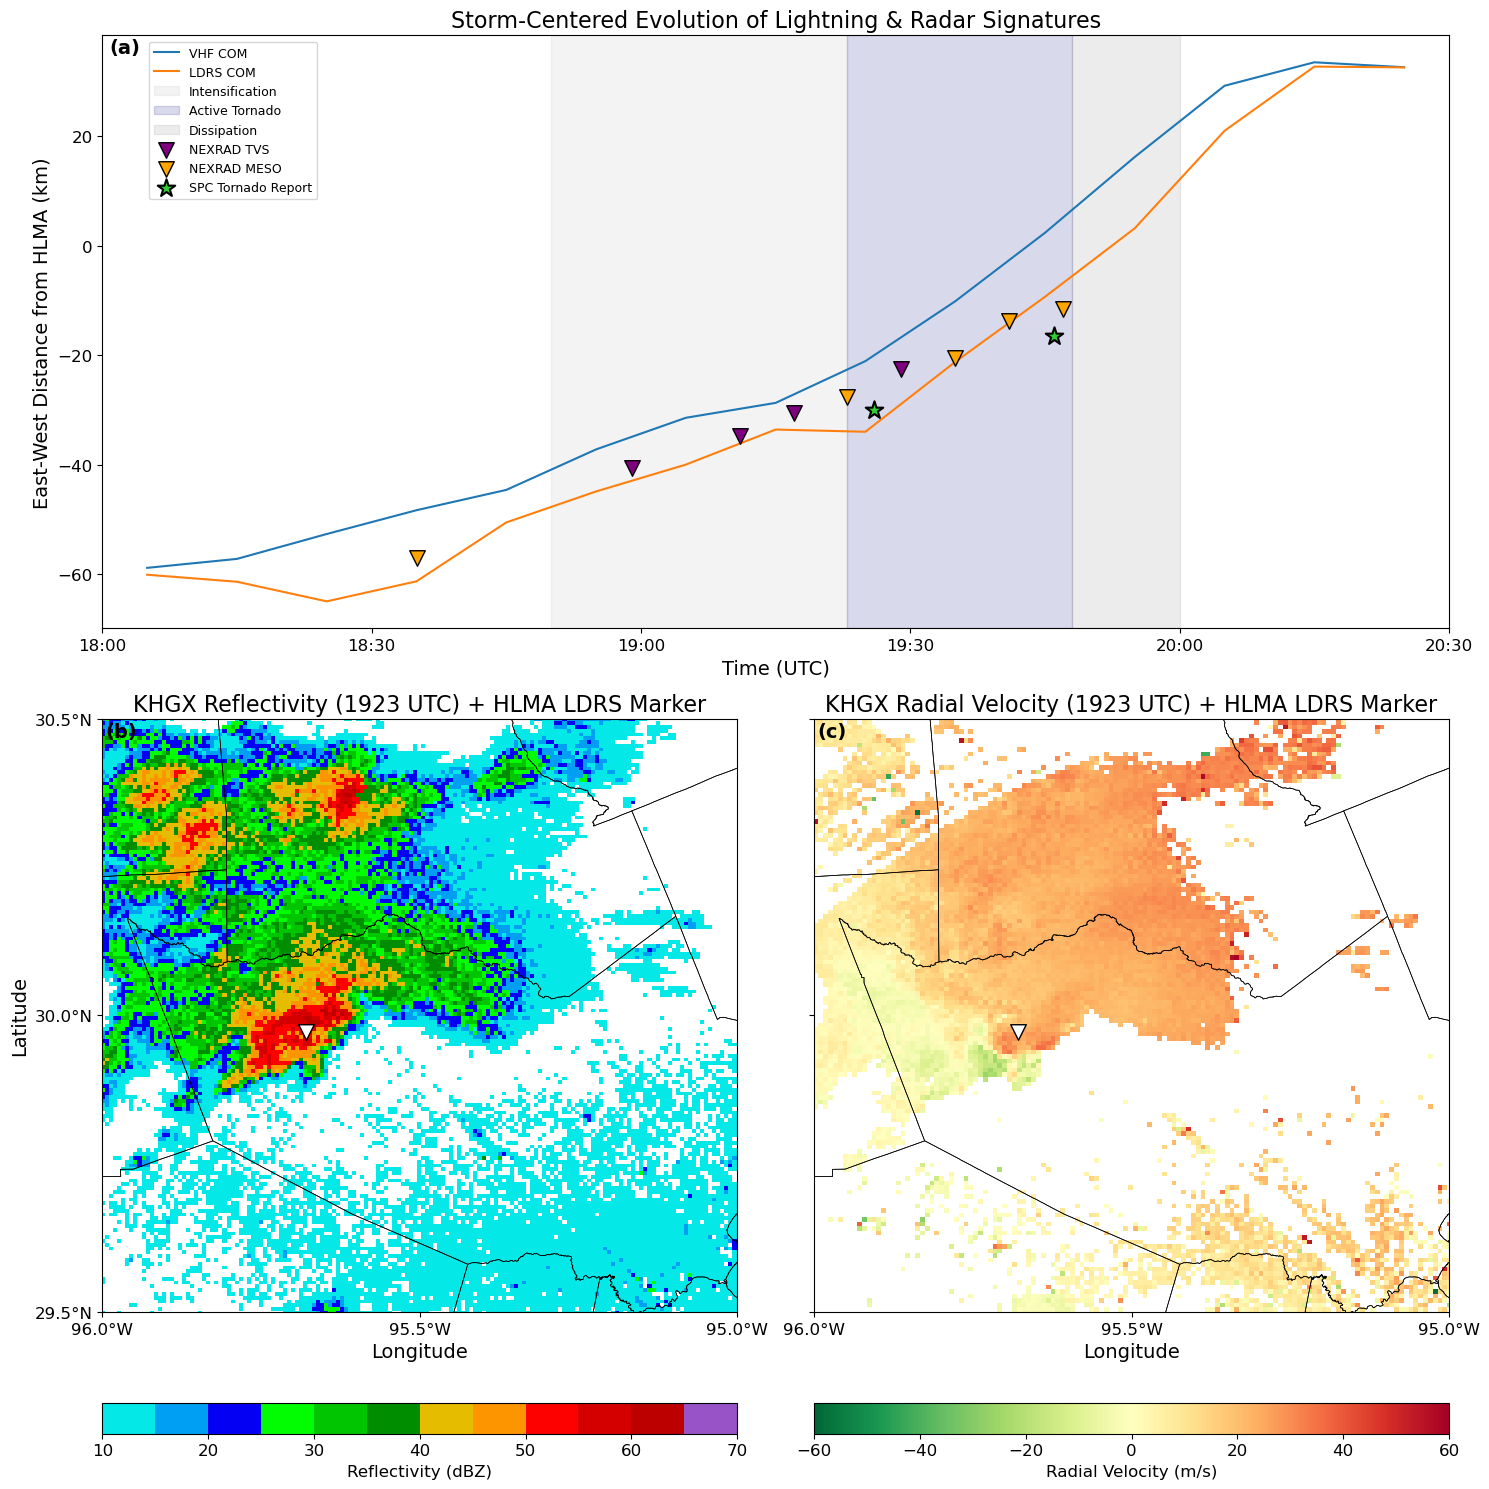

In [6]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2, width_ratios=[1.0, 1.0], height_ratios=[0.95, 0.95, 0.05])

# fig a
ax1 = fig.add_subplot(gs[0, :])

# vhf com
ax1.plot(vhf_com.index, vhf_com.x, label="VHF COM")

# ldrs com
ax1.plot(ldrs.datetime, ldrs.x, label="LDRS COM")

# tornado phases
ax1.axvspan(pd.Timestamp("2025-11-24 18:50"), pd.Timestamp("2025-11-24 19:23"), color="silver", alpha=0.18, label="Intensification")
ax1.axvspan(pd.Timestamp("2025-11-24 19:23"), pd.Timestamp("2025-11-24 19:48"), color="navy", alpha=0.15, label="Active Tornado")
ax1.axvspan(pd.Timestamp("2025-11-24 19:48"), pd.Timestamp("2025-11-24 20:00"), color="gray", alpha=0.15, label="Dissipation" )

# tvs events
ax1.scatter(tvs_events.datetime, tvs_events.x, marker="v", s=125, color="purple", edgecolor="black", zorder=6, label="NEXRAD TVS" )

# meso events
ax1.scatter(meso_events.datetime, meso_events.x, marker="v", s=125, color="orange", edgecolor="black", zorder=6, label="NEXRAD MESO" )

# spc storm reports
ax1.scatter(spc.datetime, spc.x, marker="*", s=175, color="limegreen", edgecolor="black", linewidth=1.5, zorder=7, label="SPC Tornado Report")

# axes formatting
ax1.set_xlim(TIME_START, TIME_END)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax1.set_ylim(-80, 40)
ax1.set_ylabel("East-West Distance from HLMA (km)", fontsize=14)
ax1.set_xlabel("Time (UTC)", fontsize=14)
ax1.set_title("Storm-Centered Evolution of Lightning & Radar Signatures", fontsize=16)
ax1.legend(loc="upper left", bbox_to_anchor=(0.03, 1), fontsize=9)
ax1.text(0.005, 0.97, "(a)", transform=ax1.transAxes, fontsize=14, fontweight="bold")

# setting up axes for fig b and c
ax2 = fig.add_subplot(gs[1, 0])
cax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[1, 1], sharey=ax2)
cax3 = fig.add_subplot(gs[2, 1])
plt.setp(ax3.get_yticklabels(), visible=False)

# fig b
pm_ref = ax2.pcolormesh(Lon_r, Lat_r, Z, cmap=nws_cmap, norm=nws_norm, shading="auto")
cbar_ref = fig.colorbar(pm_ref, cax=cax2, orientation='horizontal')
cbar_ref.set_label("Reflectivity (dBZ)", fontsize=12)
cbar_ref.minorticks_off()
ax2.scatter(CURL_LON, CURL_LAT, s=125, marker="v", color="white", edgecolor="black",)
county_gdf.geometry.boundary.plot(ax=ax2, linewidth=0.5, color='black')

# axes formatting
ax2.set_aspect('auto')
ax2.set_xlim(-96, -95)
ax2.set_ylim(29.5, 30.5)
ax2.set_xticks([-96, -95.5, -95])
ax2.set_yticks([29.5, 30.0, 30.5])
ax2.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
ax2.set_title("KHGX Reflectivity (1923 UTC) + HLMA LDRS Marker", fontsize=16)
ax2.set_xlabel("Longitude", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.text(0.005, 0.97, "(b)", transform=ax2.transAxes, fontsize=14, fontweight="bold")

# fig c
pm_vel = ax3.pcolormesh(Lon_v, Lat_v, Vr, cmap=vr_cmap, vmin=-vr_max, vmax=vr_max, shading="auto")
cbar_vel = fig.colorbar(pm_vel, cax=cax3, orientation='horizontal')
cbar_vel.set_label("Radial Velocity (m/s)", fontsize=12)
ax3.scatter(CURL_LON, CURL_LAT, s=125, marker="v", color="white", edgecolor="black",)
county_gdf.geometry.boundary.plot(ax=ax3, linewidth=0.5, color='black')

# axes formatting
ax3.set_aspect('auto')
ax3.set_xlim(-96, -95)
ax3.set_xticks([-96, -95.5, -95])
ax3.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax3.set_title("KHGX Radial Velocity (1923 UTC) + HLMA LDRS Marker", fontsize=16)
ax3.set_xlabel("Longitude", fontsize=14)
ax3.text(0.005, 0.97, "(c)", transform=ax3.transAxes, fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("figure4.png", bbox_inches="tight")
plt.show()